<a href="https://colab.research.google.com/github/YoanaKC/The-eagles/blob/main/Revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# Load the dataset
dataset_name = "oxford_iiit_pet"
split_names = ["train", "test"]

dataset, info = tfds.load(dataset_name, split=split_names, as_supervised=True, with_info=True)

train_ds, test_ds = dataset
NUM_CLASSES = info.features['label'].num_classes  # Get number of pet breeds


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.COX68A_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.COX68A_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [ ]:
IMG_SIZE = 224  # Standard size for MobileNet
BATCH_SIZE = 32

# Function to preprocess images
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize image
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values
    return image, label

# Data Augmentation
def augment(image, label):
    image, label = preprocess(image, label)
    image = tf.image.random_flip_left_right(image)  # Random horizontal flip
    image = tf.image.random_brightness(image, max_delta=0.1)  # Random brightness
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Random contrast
    return image, label

# Apply transformations
train_ds = train_ds.map(augment).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
model_url = "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2"
hub_layer = hub.KerasLayer(model_url, trainable=True)  # Enable fine-tuning


In [ ]:
# Load MobileNetV2 as a feature extractor (without the top classification layer)
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,  # Remove the default classification layer
                                               weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add custom classification layers
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),  # Converts feature maps into a single vector
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),  # Dropout to prevent overfitting
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')  # Output layer
])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Adjusted LR for stability
              loss='sparse_categorical_crossentropy',  # Suitable for multi-class classification
              metrics=['accuracy'])


In [ ]:
history = model.fit(train_ds, epochs=10, validation_data=test_ds)


Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 41s 254ms/step - accuracy: 0.1085 - loss: 3.4641 - val_accuracy: 0.4876 - val_loss: 2.4273
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 38s 290ms/step - accuracy: 0.4615 - loss: 2.2509 - val_accuracy: 0.7127 - val_loss: 1.4183
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 23s 196ms/step - accuracy: 0.6493 - loss: 1.4288 - val_accuracy: 0.7852 - val_loss: 0.9659
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 187ms/step - accuracy: 0.7317 - loss: 1.0360 - val_accuracy: 0.8144 - val_loss: 0.7548
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 191ms/step - accuracy: 0.7730 - loss: 0.8369 - val_accuracy: 0.8335 - val_loss: 0.6413
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 32s 281ms/step - accuracy: 0.8057 - loss: 0.7051 - val_accuracy: 0.8422 - val_loss: 0.5775
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 32s 280ms/step - accuracy: 0.8303 - loss: 0.6224 - val_accuracy: 0.8506 - val_loss: 0.5347
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 41s 282ms/step - accuracy: 0.8380 - loss: 0

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy:.2f}")


115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - accuracy: 0.8597 - loss: 0.4633
Test Accuracy: 0.86


In [ ]:
model.save("pet_detector_model.h5")


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load the Oxford-IIIT Pet Dataset
dataset_name = "oxford_iiit_pet"
dataset, info = tfds.load(dataset_name, split="train", with_info=True)


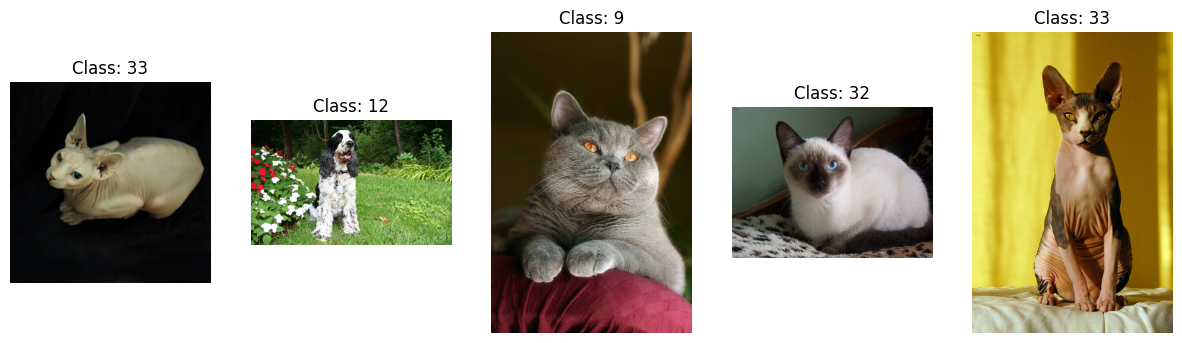

In [ ]:
def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i, data in enumerate(dataset.take(num_images)):
        image = data['image'].numpy()  # Convert tensor to NumPy
        label = data['label'].numpy()  # Get class label

        axes[i].imshow(image)
        axes[i].axis("off")
        axes[i].set_title(f"Class: {label}")

    plt.show()

# Display 5 sample images
show_images(dataset)


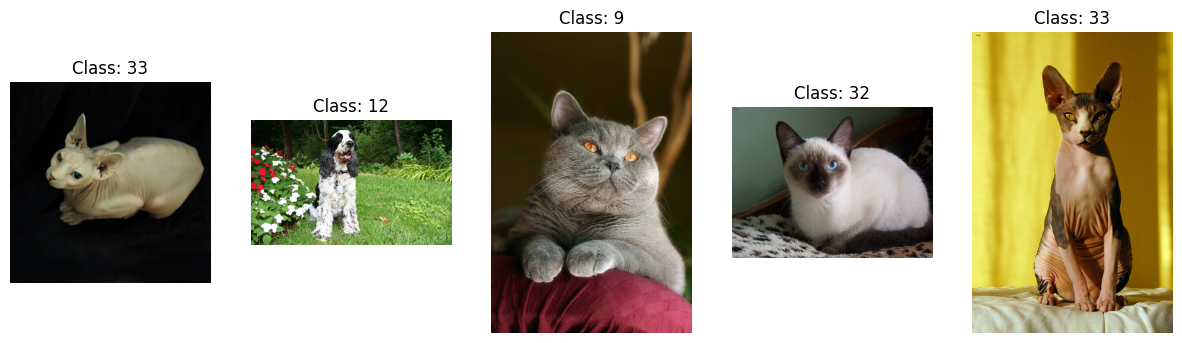

In [ ]:
def show_images_with_boxes(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i, data in enumerate(dataset.take(num_images)):
        image = data['image'].numpy()
        label = data['label'].numpy()

        # If bounding boxes exist
        if 'objects' in data:
            boxes = data['objects']['bbox'].numpy()
            for box in boxes:
                ymin, xmin, ymax, xmax = box
                h, w, _ = image.shape
                plt.gca().add_patch(plt.Rectangle((xmin * w, ymin * h),
                                                  (xmax - xmin) * w,
                                                  (ymax - ymin) * h,
                                                  edgecolor='red',
                                                  linewidth=2, fill=False))

        axes[i].imshow(image)
        axes[i].axis("off")
        axes[i].set_title(f"Class: {label}")

    plt.show()

# Display images with bounding boxes
show_images_with_boxes(dataset)
